# Precipitation Data 

### Research goals 
- Analyze climate data to explore climate conditions during our upcoming trip to Hawaii (Feb 28 to March 5)
- Use Jupyter Notebook to help create an API of the climate data using Flask 

### Analysis
- From the data collected from the previous year, precipitation falls to a range of 0-6 inches, depending on the month. On average, precipitation is less than 1 inch. 

- The average temperature generally spans around the mid-70s, with lows at 60 and highs at 80.

- Considering the daily normals based on historic data, the average temperature is at armound 70 degrees, with lows at 57 degrees and highs at 80 degrees. Based these data obeservations, the climate is likely to be comfortably warm during our trip!

### Resources
- SQL Alchemy, Pandas, and Matplotlib 
- Flask (see flaskapp.py)

In [1]:
# import dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# initialize inspector to check columns from tables
inspector = inspect(engine)

In [11]:
# check columns from Station table
columns = inspector.get_columns('station')

for column in columns: 
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# check columns from Measurement table
columns = inspector.get_columns('measurement')

for column in columns: 
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis


### Research questions

- What does precipitation look like from the previous year? 

- From this data, what kind of statistics can be useful for our analysis?

- Design several queries to help create APIs for our Flask app

- What is the average temperature, based on historical data, for our trip dates?

- What is the daily normals, based on historical data, for our trip dates?

In [13]:
# Check last date from measurement table
engine.execute('SELECT * FROM measurement ORDER BY date DESC LIMIT 5').fetchall()

[(2724, 'USC00519397', '2017-08-23', 0.0, 81.0),
 (7635, 'USC00514830', '2017-08-23', 0.0, 82.0),
 (12187, 'USC00519523', '2017-08-23', 0.08, 82.0),
 (19550, 'USC00516128', '2017-08-23', 0.45, 76.0),
 (2723, 'USC00519397', '2017-08-22', 0.0, 82.0)]

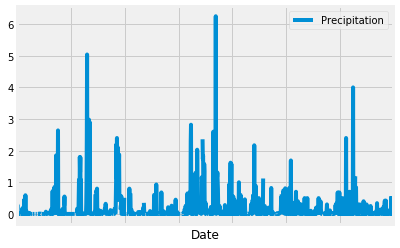

In [35]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= "2016-8-18").\
    order_by(Measurement.date).all()

# store results as list comprehension
precipitation_date = [result[0] for result in results]
precipitation_data = [result[1] for result in results]

# put results in dataframe 
precipitation_df = pd.DataFrame({"Date": precipitation_date, 
                  "Precipitation": precipitation_data})

# set index using dates
precipitation_df = precipitation_df.set_index(precipitation_df.columns[0])

# plot data and save fig 
precipitation_df.plot()
plt.xlabel("Date")
plt.tick_params(labelbottom=False)
plt.legend(loc="best")
plt.gcf()
plt.savefig("Images/precipitation.png")
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_stats = pd.DataFrame(precipitation_df["Precipitation"].describe())
precipitation_stats

,Precipitation
count,1267.000000
mean,0.165927
std,0.453913
min,0.000000
25%,0.000000
50%,0.000000
75%,0.105000
max,6.250000


In [16]:
# create query to retrieve the last 12 months of temperature data (for FLASK app)
results = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= "2016-8-18").\
    order_by(Measurement.date).all()

# store date and temperature data as list comprehension 
temp_date = [result[0] for result in results]
temp_data = [result[1] for result in results]

# put results in dataframe
temp_df = pd.DataFrame({"Date": temp_date, 
                  "Temperature": temp_data})
# check dataframe
temp_df.head()

,Date,Temperature
0,2017-01-01,62.0
1,2017-01-01,66.0
2,2017-01-01,74.0
3,2017-01-01,74.0
4,2017-01-01,72.0


In [17]:
# Design a query to show how many stations are available in this dataset
results_by_station = session.query(Measurement.station).\
    group_by(Measurement.station).count()
results_by_station

9

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.id)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station

session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).first()

(54.0, 85.0, 71.66378066378067)

In [20]:
# Choose the station with the highest number of temperature observations
session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).first()

('USC00519281', 2772)

In [21]:
# Query the last 12 months of temperature observation data for this station 

# check last measurement date for this station 
session.query(Measurement.date).\
    filter(Measurement.station == 'USC00519281').\
    order_by(Measurement.date.desc()).first()

('2017-08-18')

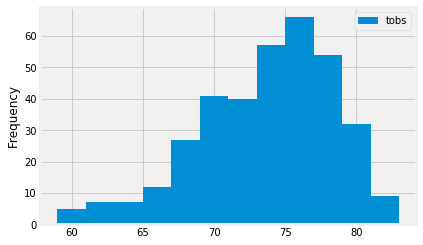

In [36]:
# perform query for temperature observation data and plot results as a histogram
results = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= "2016-08-18").\
    order_by(Measurement.date).all()

# put query results in dataframe 
highest_temp = pd.DataFrame(results)

# plot results as histogram and save fig 
highest_temp.plot.hist(bins=12)
plt.savefig("Images/temperature.png")
plt.show()

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for our trip using the previous year's data for those same dates.

calc_temps('2017-02-28', '2017-03-05')

[(64.0, 72.02777777777777, 78.0)]

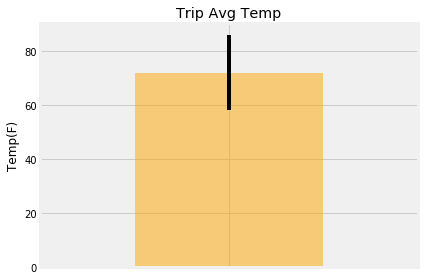

In [37]:
# create a query to determine the tmin, tavg, and tmax for our trip dates
results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= '2017-02-28').filter(Measurement.date <= '2017-03-05').all()

# store results individualy using list comprehensions
results_avg = [result[1] for result in results]
max_result = [result[0] for result in results]
min_result = [result[2] for result in results]

# create range for error bar
error = max_result[0] - min_result[0]

# store tavg values as dataframe 
results_df = pd.DataFrame(results_avg)

# plot the results from previous query as a bar chart and save fig
results_df.plot(kind="bar", alpha=0.5, color='orange', yerr=error, legend=None, title="Trip Avg Temp")
plt.ylabel("Temp(F)")
plt.tick_params(labelbottom=False)
plt.tight_layout()
plt.savefig("Images/trip_temperature_average.png")
plt.show()

In [27]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date.between("2017-02-28","2017-03-05")).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

[('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0)]

## Daily Normals
- We would like to calcualte the daily normals based on historical data to help us predict climate conditions for our trip

In [29]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [30]:
# calculate the daily normals for our trip

# createa a query for our trip dates
results = session.query(Measurement.date).\
    filter(Measurement.date.between("2017-02-28","2017-03-05")).\
    group_by(Measurement.date).\
    order_by(Measurement.date.asc()).all()

# store result as a list and dataframe 
results_list = [result[0] for result in results]
df = pd.DataFrame({"date": results_list})

# create empty columns in dataframe
dates_list = []
normals = []
df["tmin"] = ""
df["tavg"] = ""
df["tmax"] = ""

# use for loop to add calculations to individual columns from daily normals 
for index,row in df.iterrows():
    dates = row["date"]
    d = dates.replace("2017-","")
    normals.append(daily_normals(d))
    
    for result in normals: 
        n = result[0][0]
        a = result[0][1]
        m = result[0][2]
        
    df.loc[index, "tmin"] = n
    df.loc[index, "tavg"] = a
    df.loc[index, "tmax"] = m

# convert data types of columns to int
df["tmin"] = df["tmin"].apply(pd.to_numeric)
df["tavg"] = df["tavg"].apply(pd.to_numeric)
df["tmax"] = df["tmax"].apply(pd.to_numeric)

# set index using date column
df = df.set_index(df.columns[0])
df

,tmin,tavg,tmax
date,,,
2017-02-28,65.0,70.655172,80.0
2017-03-01,64.0,70.032787,76.0
2017-03-02,61.0,70.366667,78.0
2017-03-03,60.0,70.068966,78.0
2017-03-04,57.0,69.272727,77.0
2017-03-05,60.0,67.890909,76.0


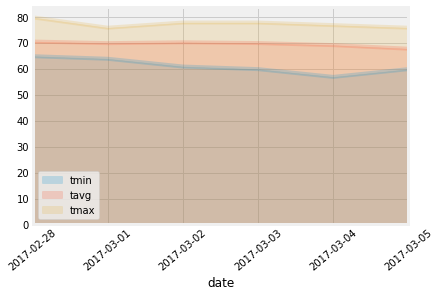

In [38]:
# plot results as area plot and save fig
df.plot.area(stacked=False, alpha=0.2)
plt.xticks(rotation=40)
plt.savefig("Images/daily_normals.png")
plt.show()